In [73]:
import matplotlib.pyplot as plt
import time
import os
import numpy as np

In [74]:
def printProgressBar(iteration, total, prefix='', suffix='', decimals=1, length=100, fill='█', printEnd="\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 *
                                                     (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()


def cross_validation_split(cross_validate_num, dataset):
    cross_len = int(round((len(dataset) * cross_validate_num), 0))
    block = []
    random_set = []
    reminder_set = []
    for i in range(10):
        rand = np.random.randint(0, 10)
        while random_set.__contains__(rand):
            rand = np.random.randint(0, 10)
        random_set.append(rand)
        block.append(dataset[i * cross_len:cross_len + (i * cross_len)])
        if i == 9 and sum([len(b) for b in block]) < len(dataset):
            reminder_set = dataset[cross_len +
                                   (i * cross_len):len(dataset)]
    return {
        "data_block": block,
        "rand_set": random_set,
        "rem_set": reminder_set
    }


def select_validate(block, random_set, c, rem_set):
    cross_valid = block[random_set[c]]
    train_idx = random_set.copy()
    train_idx.remove(random_set[c])
    train = []
    for n in range(9):
        train += block[train_idx[n]]
        if c == 9 and n == 8:
            train += rem_set
    return {
        "train": train,
        "cross_valid": cross_valid
    }

In [75]:
def sigmoid(x):
    return 1 / (1+np.e**(-x))


class Node:
    def __init__(self):
        self.input = []
        self.y = []
        self.w = []
        self.b = 0.0

    def initialWeight(self, n):
        self.w = np.array(np.random.uniform(-1, 1, size=n)).reshape((n, 1))

    def addInput(self, inputVector):
        self.input = inputVector

    def updateWeight(self, w, i):
        self.w[i] = w

    def calculateOutput(self, net):
        if len(net) != 0 and len(self.w) != 0:
            self.y = sigmoid(np.array(net).dot(self.w)[0] + self.b)
        else:
            self.y = self.input

def buildLayer(node):
    return [Node() for i in range(node)]

class Model:
    def __init__(self):
        self.chromosome = []
        self.layers = []

    def create(self, inputLayer, hiddenLayers, outputLayer):
        self.inputLayer = inputLayer
        self.hiddenLayers = hiddenLayers
        self.outputLayer = outputLayer

        self.layers.append(inputLayer)
        for layer in self.hiddenLayers:
            self.layers.append(layer)

        self.layers.append(outputLayer)

        for node in self.outputLayer:
            node.initialWeight(
                n=len(self.hiddenLayers[len(self.hiddenLayers) - 1]))
            for w in node.w:
                self.chromosome.append(w)

        for l, layer in enumerate(self.hiddenLayers):
            for node in layer:
                if l == 0:
                    n = len(self.inputLayer)
                else:
                    n = len(self.hiddenLayers[l-1])
                node.initialWeight(n)
                for w in node.w:
                    self.chromosome.append(w)
        self.chromosome = np.array(self.chromosome)

    def updateNeuralNetwork(self):
        count = 0
        for node in self.outputLayer:
            for i in range(len(node.w)):
                node.w[i] = self.chromosome[count]
                count = count+1
        for layer in self.hiddenLayers:
            for node in layer:
                for i in range(len(node.w)):
                    node.w[i] = self.chromosome[count]
                    count = count+1

    def feed_forward(self, inputVector):
        for l, layer in enumerate(self.layers):
            for i, node in enumerate(layer):
                if l == 0:
                    node.addInput(inputVector[i])
                    node.calculateOutput([])
                else:
                    net = [prev.y for prev in self.layers[l-1]]
                    node.calculateOutput(net)

    def evaluate(self, data):
        MSE = []
        for train in data:
            self.feed_forward(inputVector=train['input'])
            sum_err = []
            for i, node in enumerate(self.outputLayer):
                sum_err.append(
                    np.power((node.y - train['desire_output'][i]), 2))
            MSE.append(np.sum(sum_err))
        return 1/(1+np.average(MSE))


In [76]:
def preprocessData():
    file = open('./wdbc.data', 'r')
    data = []
    for row in file.readlines():
        line = row.split(',')
        line[len(line)-1] = line[len(line) - 1].split('\n')[0]
        dic = {
            'input': [],
            'desire_output': [],
        }
        dic['input'] = [float(d) for d in line[2:32]]
        if line[1] == 'M':
            dic['desire_output'].append(0)
        else:
            dic['desire_output'].append(1)
        data.append(dic)

    col_length = len(data[0]['input'])

    mydict = {}
    for col in range(col_length):
        mydict.update({f'{col}': []})

    for d in data:
        for col, val in enumerate(d['input']):
            mydict[f'{col}'].append(val)

    max_val = []
    for col in range(col_length):
        max_val.append(np.max(mydict[f'{col}']))

    for d in data:
        for col in range(col_length):
            d['input'][col] = d['input'][col] / max_val[col]

    return data


def crossover(p1, p2):
    selected_chromosome = []

    for i in range(len(p1.chromosome)):
        rand = np.random.randint(0, 2)
        if rand == 0:
            selected_chromosome.append(p1.chromosome[i])
        else:
            selected_chromosome.append(p2.chromosome[i])

    child = Model()
    child.create(buildLayer(node=len(p1.inputLayer)), [buildLayer(node=len(layer))
                                                       for layer in p1.hiddenLayers], buildLayer(node=len(p1.outputLayer)))
    child.chromosome = np.array(selected_chromosome)
    child.updateNeuralNetwork()
    return child


def mutation(prototype):
    p_copy = prototype
    new_chromosome = []
    for l, layer in reversed(list(enumerate(p_copy.layers))):
        if l > 0:
            for node in layer:
                mutation_prob = np.random.uniform(0, 1)
                if mutation_prob > 0.35:
                    for i, w in enumerate(node.w):
                        epsilon = np.random.uniform(-1, 1)
                        node.updateWeight(w + epsilon, i)
    for l, layer in reversed(list(enumerate(p_copy.layers))):
        if l > 0:
            for node in layer:
                for w in node.w:
                    new_chromosome.append(w)

    p_copy.chromosome = np.array(new_chromosome)
    return p_copy


def SUS(ranked_population):
    min = 0.8
    max = 2 - min

    n = len(ranked_population)
    for i, p in enumerate(ranked_population):
        ri = i + 1
        pi = (min + ((max-min)*((ri-1)/(n-1))))/n
        p['pi'] = pi
        p['ni'] = n * pi

    ptr = np.random.uniform(0, 1)
    sum = 0
    selected_population = []
    for i, p in enumerate(ranked_population):
        sum += p['ni']
        while sum > ptr:
            selected_population.append(p)
            ptr += 1
    return selected_population


def initPopulation(n):
    population = []
    for i in range(n):
        inputLayer = buildLayer(node=30)
        hiddenLayers = [buildLayer(5),buildLayer(3)]
        outputLayer = buildLayer(node=1)

        p = Model()
        p.create(inputLayer, hiddenLayers, outputLayer)
        population.append(p)
    return population

In [77]:
data = preprocessData()

population_n = 30
t_max = 120

0.8084792474905401
0.8089019959397588
0.8065824901349633
0.8087864204310179
0.8124753770610986
0.8094581521765916
0.8085977771681816
0.8169293660269947
0.8128431207975909
0.8184189182447693
0.8139523951824699
0.819673288370231
0.8121840350049411
0.8232166638427952
0.8257483710027793
0.8096104040378369
0.8073159970749634
0.8124006749649008
0.8134417053264322
0.8272989267131531
0.8148574012628297
0.817093753395152
0.8188927091309033
0.8285334756922115
0.8168877567908234
0.8073180069062924
0.8266157254580068
0.8398474016231662
0.8153199506460606
0.8153569303496166
0.8167298780511022
0.8244937884169395
0.8223868832207065
0.8211684311705848
0.8339181653790787
0.8267643676537213
0.8287212657757234
0.8224269993522584
0.8211465040903975
0.842096162018321
0.8059409507099156
0.8094516146062259
0.8139770377693627
0.8320267694378501
0.8248814146478882
0.84055852521427
0.8842660552229377
0.8174052492636301
0.8286429947206682
0.8690231515736996
0.815884870007327
0.839957620260222
0.8563112613316333


0.8333526587137302
0.8453426313289247
0.8459928750098432
0.8350420316254268
0.8324715754422711
0.8376916930458109
0.8231469890996473
0.8268613553939466
0.851228065142413
0.8343298384659789
0.8628812391320143
0.8373453513144459
0.8384350634261817
0.872444250542626
0.8670260835404429
0.8679824436823383
0.8908333459867737
0.8953966648949455
0.8920428733372574
0.8182840228830965
0.7954893610965321
0.8678034327568978
0.8245189977227627
0.8332583942578309
0.8262896007480031
0.8468879974843584
0.8604102819911019
0.8406065488918577
0.8616149043202361
0.8433840628280056
0.8317115460195456
0.8267459897499492
0.8452557256101058
0.8619077322395674
0.8604788674612263
0.846282882356594
0.8491086487691539
0.8350935334195392
0.8790662455101409
0.8498526810389458
0.8380151368680037
0.8243029553939697
0.8196947020335699
0.864156222271611
0.8533929230652014
0.839576043288655
0.8532323055367028
0.8252325142600772
0.813936143287846
0.8020942693925782
0.8087922123915128
0.8279557312365486
0.8403788807818645

0.8045356803003512
0.8096397245292889
0.8199000692408625
0.827137119912731
0.821311270515554
0.8139449623581263
0.8108721995054144
0.8157892397153104
0.8352345390841286
0.8387343333959577
0.8213124525508119
0.8219794609697009
0.8212395244890709
0.8189156967092265
0.8453078962022029
0.8168727187109265
0.8225344253352798
0.8343867910216867
0.8099543037970752
0.8264067985058585
0.8106349837921241
0.8716784634190127
0.8643040999594598
0.8370365277950107
0.863639329888084
0.8712662063608142
0.8484763433553917
0.8310296109503182
0.8290929818994263
0.8166139196802447
0.8352596829780231
0.819543251863433
0.8415703198113181
0.8199460460040034
0.8094817300087096
0.8230638957982829
0.861861890945683
0.8307959217790012
0.81742345844515
0.8392521076193799
0.8537214589420167
0.8489181908200835
0.8553659345017641
0.8513697765461317
0.8427803611943635
0.8388816337092041
0.8310085612515947
0.8195839955298363
0.8386401092579316
0.8691064289242746
0.856543437302174
0.849755334305065
0.8516843744931778
0.

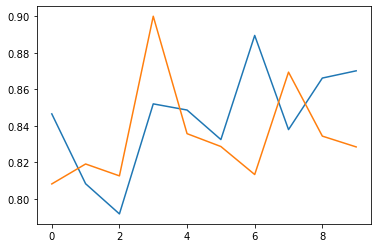

In [78]:
cross_data = cross_validation_split(cross_validate_num=0.1, dataset=data)
block = cross_data["data_block"]
rand_set = cross_data["rand_set"]
reminder_set = cross_data["rem_set"]

initial_population = initPopulation(n=population_n)

cross_validation_plot = []
train_plot = []
for c in range(10):
    res = select_validate(block, rand_set, c, reminder_set)
    train = res["train"]
    test = res["cross_valid"]
    population = initial_population

    for t in range(t_max):
        ranked_based = []
        best = []

        for i, p in enumerate(population):
            MSE = p.evaluate(train)
            dict_p = {
                "MSE": MSE,
                "Model": p
            }
            ranked_based.append(dict_p)
        
        # selction process
        ranked_based = sorted(ranked_based, key=lambda k: k['MSE'])
        if t+1 == t_max:
            train_plot.append(ranked_based[len(ranked_based) - 1]['MSE'])
        
        mating_pool = SUS(ranked_based)
        # mating process and crossover
        next_gen = []
        mating_count = 1
        while mating_count <= len(mating_pool)*0.5:
            parents = []
            pIdx = []
            for i in range(2):
                rand = np.random.randint(0, len(mating_pool))
                while pIdx.__contains__(rand):
                    rand = np.random.randint(0, len(mating_pool))
                
                pIdx.append(rand)
                parents.append(mating_pool[int(rand)])

            child1 = crossover(parents[0]['Model'], parents[1]['Model'])
            next_gen.append(child1)
            mating_count += 1

        # select and mutate from mating pool
        while len(next_gen) < population_n:
            rand = np.random.randint(0, len(mating_pool))
            pool_p = mating_pool[int(rand)]
            child = mutation(prototype=pool_p['Model'])
            next_gen.append(child)

        population = next_gen
#         print('t : ', t+1)
        print(mating_pool[len(mating_pool) - 1]['MSE'])

    # cross validation
    printProgressBar(0, len(population),
                     prefix=f'cross validationing... {c+1}', length=25)
    sse_cross = []
    for i, p in enumerate(population):
        SSE = p.evaluate(test)
        sse_cross.append(SSE)
        printProgressBar(i+1, len(population),
                         prefix=f'cross validationing... {c+1}', length=25)
    cross_validation_plot.append(np.max(sse_cross))

plt.plot(cross_validation_plot,label='Cross validation test')
plt.plot(train_plot, label='Train')
print(cross_validation_plot)
print(train_plot)
plt.show()